In [63]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [64]:
pwd

'/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master'

In [65]:
class ConfigClass():
    train_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/'
    test_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/testing/'   
    train_batch_size = 64
    train_num_epochs = 100

In [66]:
from PIL import Image

# Load the image
img = Image.open("/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/s1/1.pgm.png")

# Get the dimensions
width, height = img.size
print("Width:", width, "Height:", height)

Width: 92 Height: 112


In [67]:
class SiameseDataset(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)
    
    
    
    
    

In [68]:
import os

train_dir = ConfigClass.train_dir
if os.path.isdir(train_dir):
    print(f"The train_dir '{train_dir}' exists and is accessible")
else:
    print(f"The train_dir '{train_dir}' does not exist or is not accessible")

The train_dir '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/' exists and is accessible


In [69]:
try:
    SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)
except Exception as e:
    print("An error occurred while accessing the image folder: ", e)

In [70]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

In [71]:
sample_image = siamese_dataset[0][0]
height, width = sample_image.shape[-2:]
print("Pixel size: {}x{}".format(width, height))


Pixel size: 100x100


In [72]:
print("Image Folder: ", image_folder)
print("Siamese Dataset: ", siamese_dataset)

Image Folder:  Dataset ImageFolder
    Number of datapoints: 740
    Root location: /Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/
Siamese Dataset:  <__main__.SiameseDataset object at 0x7f91f81db790>


In [73]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

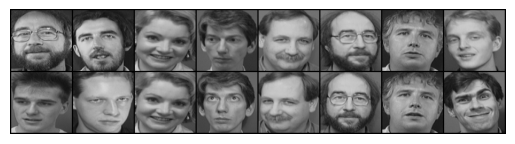

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

In [74]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [75]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

In [76]:
# class ConstrastiveLoss(torch.nn.Module):
    
#     def __init__(self, margin=1.0):
#         super(ConstrastiveLoss, self).__init__()
#         self.margin = margin
        
#     def forward(self, output1, output2, label):
#         cosine_sim = F.cosine_similarity(output1, output2, dim=1)
#         contrastive_loss = torch.mean((1 - label)*torch.pow(cosine_sim, 2)
#                                       + (label)*torch.pow(torch.clamp(self.margin - cosine_sim, min=0.0), 2))
        

        
#         return contrastive_loss

class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=0.5, threshold=0.4):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        self.threshold = threshold
        
        
    def forward(self, output1, output2, label):
        
        cosine_sim = F.cosine_similarity(output1, output2, dim=1)
        
        contrastive_loss = torch.mean((1 - label)*torch.pow(cosine_sim, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - cosine_sim, min=0.0), 2))
        
        return contrastive_loss


In [77]:
print(torch.version.cuda)

None


In [78]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cuXX/torch_stable.html



SyntaxError: invalid syntax (3878635041.py, line 1)

In [79]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork().cpu()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 0.2730385959148407
Epoch: 1 	 Loss: 0.3113538920879364
Epoch: 2 	 Loss: 0.19233438372612
Epoch: 3 	 Loss: 0.1963748037815094
Epoch: 4 	 Loss: 0.1663588434457779
Epoch: 5 	 Loss: 0.18403545022010803
Epoch: 6 	 Loss: 0.20407412946224213
Epoch: 7 	 Loss: 0.18904514610767365
Epoch: 8 	 Loss: 0.15044812858104706
Epoch: 9 	 Loss: 0.18338823318481445
Epoch: 10 	 Loss: 0.1642255038022995
Epoch: 11 	 Loss: 0.17152650654315948
Epoch: 12 	 Loss: 0.20900821685791016
Epoch: 13 	 Loss: 0.20101097226142883
Epoch: 14 	 Loss: 0.18839561939239502
Epoch: 15 	 Loss: 0.1517932116985321
Epoch: 16 	 Loss: 0.15886715054512024
Epoch: 17 	 Loss: 0.15438589453697205
Epoch: 18 	 Loss: 0.16488443315029144
Epoch: 19 	 Loss: 0.18822115659713745
Epoch: 20 	 Loss: 0.15373995900154114
Epoch: 21 	 Loss: 0.15975607931613922
Epoch: 22 	 Loss: 0.14252185821533203
Epoch: 23 	 Loss: 0.16449710726737976
Epoch: 24 	 Loss: 0.20345163345336914
Epoch: 25 	 Loss: 0.15314576029777527
Epoch: 26 	 Loss: 0.15430289506

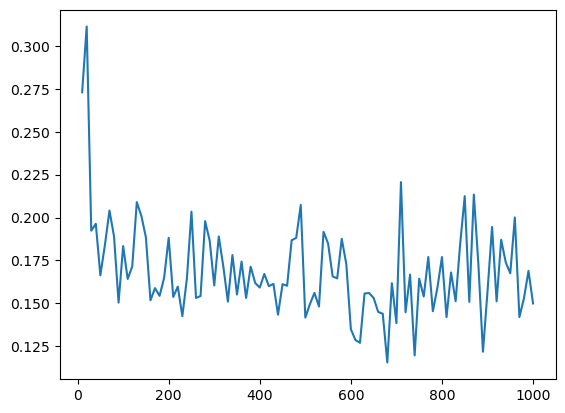

In [80]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cpu(), input2.cpu(), label.cpu()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
show_plot(counter, loss_history)

Iteration 1


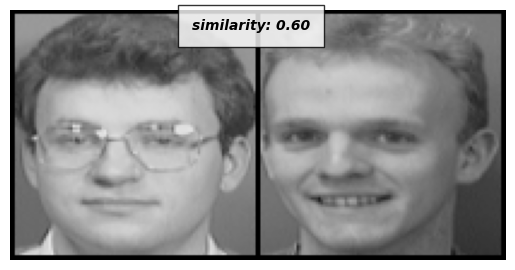

Iteration 2


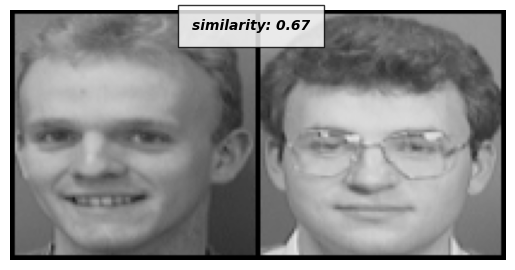

Iteration 3


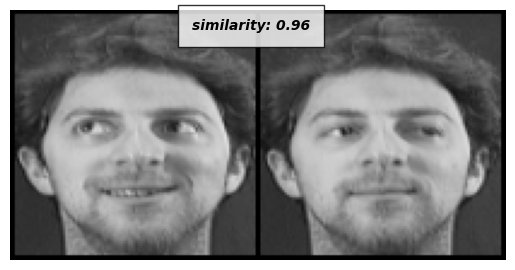

Iteration 4


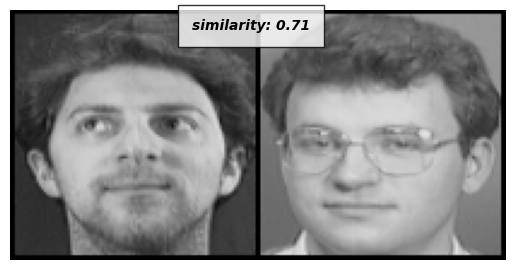

Iteration 5


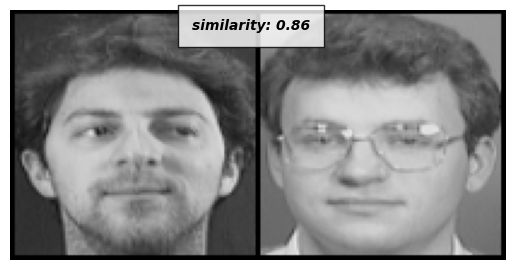

Iteration 6


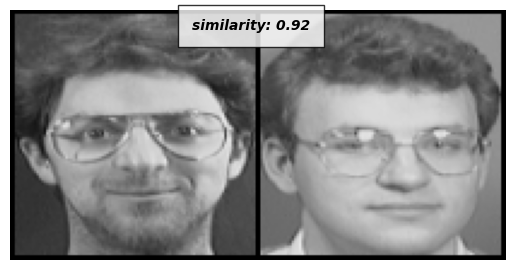

Iteration 7


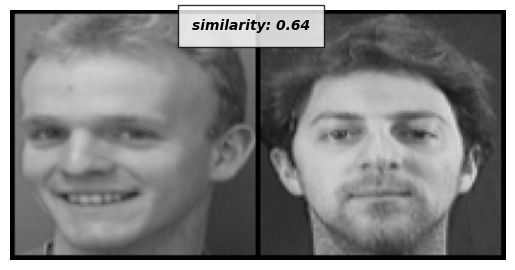

Iteration 8


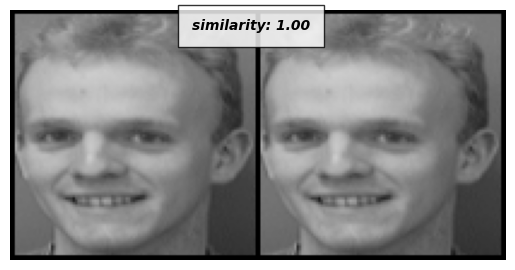

Iteration 9


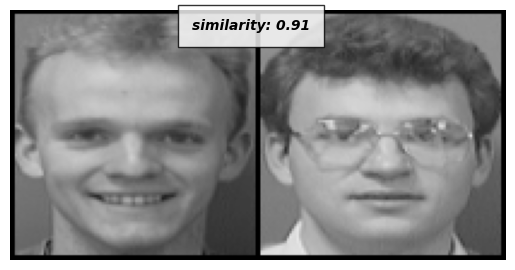

Iteration 10


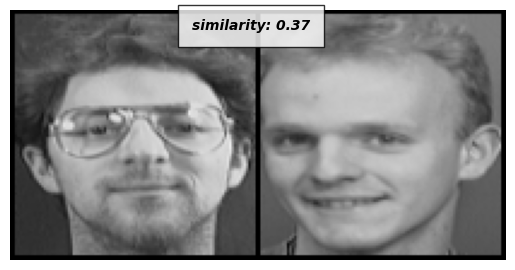

Accuracy: 0.90

Confusion Matrix:
 [[8 0]
 [1 1]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.50      0.67         2

    accuracy                           0.90        10
   macro avg       0.94      0.75      0.80        10
weighted avg       0.91      0.90      0.89        10



In [83]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(dataloader)
threshold = 0.50
correct = 0
total = 0
y_true = None
y_pred = None
    
for i in range(10):
    img0, _, _ = next(data_iter)
    _, img1, label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    
    output1, output2 = model(Variable(img0).cpu(), Variable(img1).cpu())
    distance = F.cosine_similarity(output1, output2)
    y_pred_now = [1 if d < threshold else 0 for d in distance]
    y_true_now = [label_tensor.item() for _, _, (label_tensor,) in zip(img0, img1, label)]

    if y_true is None:
        y_true = y_true_now
        y_pred = y_pred_now
    else:
        y_true.extend(y_true_now)
        y_pred.extend(y_pred_now)

    print(f"Iteration {i+1}")
    
    imshow(torchvision.utils.make_grid(merged), 'similarity: {:.2f}'.format(distance.item()))
    # Calculate accuracy
    for pred, true in zip(y_pred_now, y_true_now):
        if pred == true:
            correct += 1
        total += 1
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))